In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from scipy.stats import norm
from root_numpy import root2array
from scipy.optimize import curve_fit
from lmfit import  Model #better gaussian model

In [2]:
#from matplotlib import gridspec
#from matplotlib.colors import LogNorm
#from numpy import polyfit
#from numpy import random

In [103]:
filedir = '/Users/davidkaleko/larlite/UserDev/KalekoAna/scratch_ana/mac/MCS_paper_anafiles/'

#singlemu_recotracks, singletrack_data, singlemu_mctracks, singletrack_MC, MCBNB_recotracks
anatype = 'MCBNB_recotracks' 
#!ls -ltra $filedir
seglen = 20
myfile = 'MCSBiasStudy_%s_anaout_%dcmseg_2res_bothscatters_NONRELATIVISTICFIX.root' %( anatype, seglen )
#_NONRELATIVISTICFIX

In [104]:
titles = { 
           'singlemu_mctracks'   : 'Fully Contained Single Muon MCTracks',
           'singlemu_recotracks' : 'Fully Contained, Well Reconstructed Single Muon Tracks',
           'singletrack_data'    : 'Selected, Well Reconstructed Tracks from NumuCC Data',
           'full_range_energy'   : 'Range-Based Total Energy [GeV]',
           'singletrack_MC'      : 'Selected, Well Reconstructed Tracks from NumuCC Simulation',
           'MCBNB_recotracks'    : 'MC numuCC BNB Truth-Selected, Well Reconstructed Tracks',
           'full_MCS_energy'     : 'MCS Total Energy [GeV]',
           'true_E'              : 'True Total Energy [GeV]'
         }

latextitles = {
           'full_range_energy'   : 'E_{Range}',
           'full_MCS_energy'     : 'E_{MCS}',
           'true_E'              : 'E_{True}'
         }

In [105]:
#This df has track-by-track information (MCS energy, range energy, etc)
df = pd.DataFrame( root2array ( filedir + myfile, 'MCS_bias_tree' ) )
df['full_MCS_energy_inverse'] = 1./df['full_MCS_energy']
df['full_range_energy_inverse'] = 1./df['full_range_energy']

#This df has segment-by-segment deviation (scattering angle, etc)
segdf = pd.DataFrame(  root2array ( filedir + myfile, 'TMC_debug_tree' ) )
segdf['dthetayoverpredictedRMS'] = segdf['delta_theta_y']/segdf['predicted_RMS']
segdf['dthetayovertruepredictedRMS'] = segdf['delta_theta_y']/segdf['true_predicted_RMS']
segdf['dthetayoverpredictedRMS_fromMCS'] = segdf['delta_theta_y']/segdf['predicted_RMS_fromMCS']

segdf['dthetaxoverpredictedRMS'] = segdf['delta_theta_x']/segdf['predicted_RMS']
segdf['dthetaxovertruepredictedRMS'] = segdf['delta_theta_x']/segdf['true_predicted_RMS']
segdf['dthetaxoverpredictedRMS_fromMCS'] = segdf['delta_theta_x']/segdf['predicted_RMS_fromMCS']

#Optional driver DF tree that holds some MCTrack informationß
driverdf = pd.DataFrame( root2array ( filedir + myfile, 'driver_tree' ) )
#Merge it into the main df by run,subrun,eventid
df = df.merge(driverdf, on=['run','subrun','eventid'])
#also merge into segdf
segdf = segdf.merge(driverdf, on=['run','subrun','eventid'])

In [106]:
def gaussian(x, amp, cen, wid):
    "1-d gaussian: gaussian(x, amp, cen, wid)"
    return (amp/(np.sqrt(2*np.pi)*wid)) * np.exp(-(x-cen)**2 /(2*wid**2))

['full_length' 'full_range_energy' 'full_MCS_energy' 'true_E' 'run'
 'subrun' 'eventid' 'full_MCS_energy_inverse' 'full_range_energy_inverse'
 'MCT_PDG' 'MCT_origin']
13810
[13]


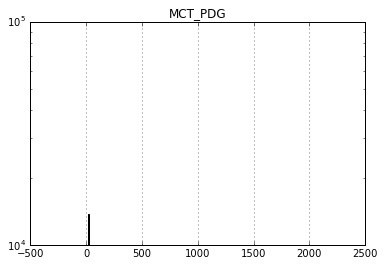

In [107]:
print df.columns.values
print len(df)
df.hist('MCT_PDG',bins=np.linspace(-500,2500,300))
fart = plt.yscale('log')
print df['MCT_PDG'].unique()

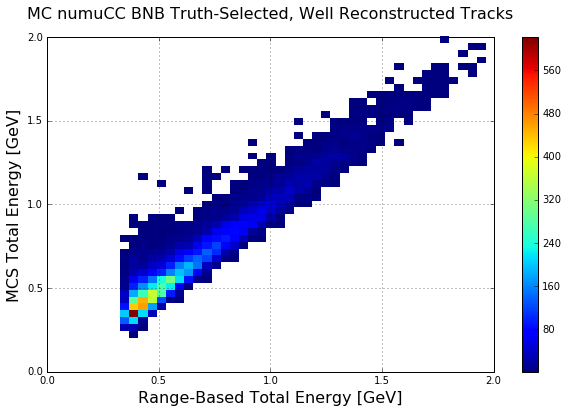

In [108]:
plt.figure(figsize=(10,6))
myx = df['full_range_energy'].values
myy = df['full_MCS_energy'].values
blah = plt.hist2d(myx,myy,bins=((np.linspace(0,2,50),np.linspace(0,2,50))),cmin=1)
blah = plt.colorbar()
blah = plt.grid(True)
blha = plt.xlabel('Range-Based Total Energy [GeV]',fontsize=16)
blha = plt.ylabel('MCS Total Energy [GeV]',fontsize=16)
blha = plt.title('%s'%titles[anatype],fontsize=16)
blha.set_y(1.04)

#blah = np.polyfit(myx,myy,1)
#p = np.poly1d(blah)
#xp = np.linspace(100,200,100)
#poop = plt.plot(xp, p(xp), 'g-',linewidth=3, label='Linear Poly Fit')
#print p

In [109]:
if anatype == 'singlemu_mctracks':
    plt.figure(figsize=(10,6))
    myx = df['true_E'].values
    myy = df['full_range_energy'].values
    blah = plt.hist2d(myx,myy,bins=((np.linspace(0,2,50),np.linspace(0,2,50))),cmin=1)
    blah = plt.colorbar()
    blah = plt.grid(True)
    blha = plt.xlabel('True Total Energy [GeV]',fontsize=16)
    blha = plt.ylabel('Range-Based Total Energy [GeV]',fontsize=16)
    blha = plt.title('%s'%titles[anatype],fontsize=16)


In [110]:
if anatype == 'singletrack_MC':

    for (pdg,name) in [ (211,'Pion MIDs'), (13,'True Muons'), (2212, 'Proton MIDs')]:
        plt.figure(figsize=(10,6))
        myx = df.query('MCT_PDG == %d or MCT_PDG == -%d'%(pdg,pdg))['full_range_energy'].values
        myy = df.query('MCT_PDG == %d or MCT_PDG == -%d'%(pdg,pdg))['full_MCS_energy'].values
        blah = plt.hist2d(myx,myy,bins=((np.linspace(0,2,50),np.linspace(0,2,50))),cmin=1)
        blah = plt.colorbar()
        blah = plt.grid(True)
        blha = plt.xlabel('Range-Based Total Energy [GeV]',fontsize=16)
        blha = plt.ylabel('MCS Total Energy [GeV]',fontsize=16)
        blha = plt.title('Selected, Well Reconstructed Tracks from NumuCC Simulation',fontsize=16)
        blha.set_y(1.04)
        plt.text(plt.xlim()[1]*0.6, plt.ylim()[1]*0.1, name, fontsize=20)

In [111]:
#Read in handscan info if working with data
if anatype == 'singletrack_data':
    filedir = '/Users/davidkaleko/Desktop/'
    myfile = 'handscan_results_kaleko.csv'
    
    hsdf = pd.read_csv(filedir + myfile,index_col=False)
       
    #Column names with spaces are hard to deal with, this is easy
    cols = hsdf.columns
    cols = cols.map(lambda x: x.replace(' ', '_') if isinstance(x, (str, unicode)) else x)
    hsdf.columns = cols
    
    #If no optional comments were typed in it shows up as NaN
    #Let's just make a column of "optional comments present" (boolean)
    
    hsdf['comments_present'] = hsdf['optional_comments'].notnull()
    
    #Let's rename things... 1_good_0_bad is only 0 if the track is definitely bad
    hsdf['definitely_bad'] = hsdf['1_good_0_bad'] == 0
    
    #maybe bad is either definitely_bad, or if comments are present (more conservative)
    hsdf['maybe_bad'] = hsdf['definitely_bad'] | hsdf['comments_present']
    
    print "total length of hsdf is",len(hsdf)
    print "number of definitely bad is",len(hsdf.query('definitely_bad'))
    print "number of maybe bad is",len(hsdf.query('maybe_bad'))
    
    #let's rename run, subrun, eventid columns to match the MCS df
    #for now just make a new column because it's easier
    hsdf['run'] = hsdf['Run']
    hsdf['subrun'] = hsdf['Subrun']
    hsdf['eventid'] = hsdf['Event_ID']
    
    df = df.merge(hsdf, on=['run','subrun','eventid'])

    segdf = segdf.merge(hsdf, on=['run','subrun','eventid'])

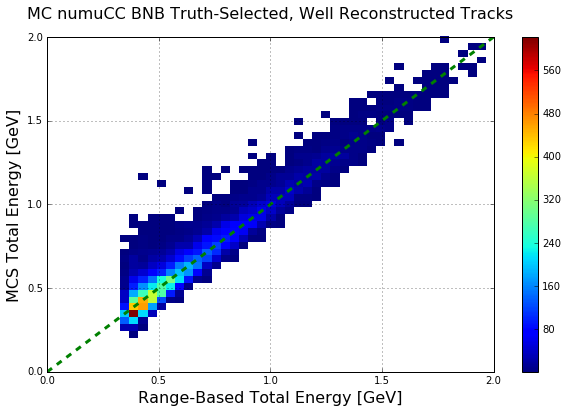

In [126]:
mybins = (np.linspace(0,2,50),np.linspace(0,2,50))
plt.figure(figsize=(10,6))
myx = df['full_range_energy'].values
myy = df['full_MCS_energy'].values
blah = plt.hist2d(myx,myy,bins=mybins,cmin=1)
blah = plt.colorbar()
blah = plt.grid(True)
blha = plt.xlabel('Range-Based Total Energy [GeV]',fontsize=16)
blha = plt.ylabel('MCS Total Energy [GeV]',fontsize=16)
blha = plt.title('%s'%titles[anatype],fontsize=16)
#blha = plt.title('Selected, Contained Muons in BNB Data',fontsize=16)
blha.set_y(1.04)
blah = plt.plot([0,100],[0,100],'g--',linewidth=3)

if anatype == 'singletrack_data':
    myquery = 'not definitely_bad'
    plt.figure(figsize=(10,6))
    myx = df.query(myquery)['full_range_energy'].values
    myy = df.query(myquery)['full_MCS_energy'].values
    blah = plt.hist2d(myx,myy,bins=mybins,cmin=1)
    blah = plt.colorbar()
    blah = plt.grid(True)
    blha = plt.xlabel('Range-Based Total Energy [GeV]',fontsize=16)
    blha = plt.ylabel('MCS Total Energy [GeV]',fontsize=16)
    blha = plt.title('Selected, Contained Muons in BNB Data',fontsize=16)
    #blah = plt.plot([0,100],[0,100],'g--',linewidth=5)
    
    myquery = 'not maybe_bad'
    plt.figure(figsize=(10,6))
    myx = df.query(myquery)['full_range_energy'].values
    myy = df.query(myquery)['full_MCS_energy'].values
    blah = plt.hist2d(myx,myy,bins=mybins,cmin=1)
    blah = plt.colorbar()
    blah = plt.grid(True)
    blha = plt.xlabel('Range-Based Total Energy [GeV]',fontsize=16)
    blha = plt.ylabel('MCS Total Energy [GeV]',fontsize=16)
    blha = plt.title('Selected, Contained Muons in BNB Data',fontsize=16)
    blha = plt.title('Selected, Contained Muons in BNB Data [Well Reconstructed]',fontsize=16)
    blha.set_y(1.04)
    #blah = plt.plot([0,100],[0,100],'g--',linewidth=5)


In [113]:
#reco-true/true
def icarus_plot(extraquery = None):
    binning = np.linspace(0.35,1,10)
    binwidth = float(binning[1]-binning[0])
    bincenters = binning + (binwidth/2)
    myreses, mystds, myerrs = [], [], []

    for x in xrange(len(binning)-1):
        
        binmin = binning[x]
        binmax = binning[x+1]
        #print "binmin = %0.2f, binmax = %0.2f"% ( binmin, binmax )
        myquery = 'full_range_energy > %f and full_range_energy < %f'%(binmin,binmax)
        if anatype == 'singletrack_data': myquery += ' and not maybe_bad'
        if extraquery is not None: myquery += ' and %s' % extraquery
        mydf = df.query(myquery)
        true = mydf['full_range_energy'].values
        reco = mydf['full_MCS_energy'].values
        mymean = ((reco-true)/true).mean()
        mystd = ((reco-true)/true).std()
        myerr = mystd / np.sqrt( float(len(true)) )
        myreses.append( mymean )
        mystds.append( mystd )
        myerrs.append( myerr )
            
    plt.figure(figsize=(10,6))
    plt.errorbar(bincenters[:-1],myreses,yerr=mystds,fmt='o--',label='Mean of Distribution, Errors = std')
    plt.ylabel('mean($\\frac{E_{MCS} - E_{Range}}{E_{Range}}$)',fontsize=25)
    plt.xlabel('Range-Based Total Energy [GeV]',fontsize=15)
    plt.grid(True)
    plt.legend(loc='best')
    t = plt.title('MCS Dispersion: %s'%titles[anatype],fontsize=16)
    t.set_y(1.04)

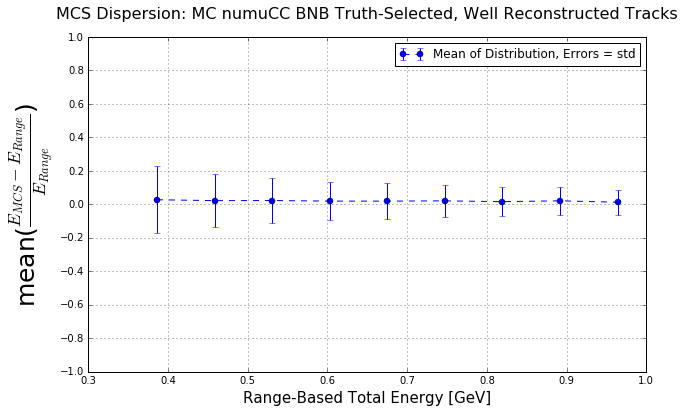

In [114]:
icarus_plot(extraquery='MCT_PDG == 13 or MCT_PDG == -13')
blah = plt.ylim((-1,1))
blah = plt.yticks(np.arange(-1, +1.1, .20))

In [115]:
def highlandE(rms):
    loverX = float(seglen)/14.
    return np.sqrt((13.6*13.6*loverX*np.square((1+0.038*np.log(loverX))))/np.square(rms))

In [116]:
segdf.columns.values

array(['full_track_len', 'full_MCS_E', 'full_range_E', 'delta_theta_x',
       'delta_theta_y', 'seg_end_x', 'seg_end_y', 'seg_end_z',
       'n_traj_points', 'seg_theta', 'seg_phi', 'counter',
       'true_segment_E', 'true_predicted_RMS', 'segment_E',
       'predicted_RMS', 'segment_E_fromMCS', 'predicted_RMS_fromMCS',
       'resid_dist', 'llbf', 'run', 'subrun', 'eventid',
       'dthetayoverpredictedRMS', 'dthetayovertruepredictedRMS',
       'dthetayoverpredictedRMS_fromMCS', 'dthetaxoverpredictedRMS',
       'dthetaxovertruepredictedRMS', 'dthetaxoverpredictedRMS_fromMCS',
       'MCT_PDG', 'MCT_origin'], dtype=object)

In [117]:
def deflection_plot(binmin,binmax,nbins,extraquery=None):
    
    fig = plt.figure(figsize=(10,6))
    
    poop = plt.grid(True)
    
    myquery = 'run < 99999999'
    if extraquery is not None: myquery += ' and %s'%extraquery
    print myquery
    mybins = np.linspace(binmin,binmax,nbins)
    
    myvar1 = 'dthetayoverpredictedRMS_fromMCS'
    myvar2 = 'dthetaxoverpredictedRMS_fromMCS'

    myvals = np.append(
        segdf.query(myquery).\
        query('%s > %f and %s < %f'%(myvar1,binmin,myvar1,binmax))[myvar1].values,
        segdf.query(myquery).\
        query('%s > %f and %s < %f'%(myvar2,binmin,myvar2,binmax))[myvar2].values
    )
        
    mystd = np.std(myvals)
    mymean = np.mean(myvals)

    datahist = plt.hist(myvals,bins=mybins,normed=True,
                             alpha=0.5,label='$\Delta\\theta/RMS$ Values')#,
                            #weights = myweights)
   
    datahist_nonorm = np.histogram(myvals,bins=mybins,normed=False)
    
    binvals = datahist[0]
    bincenters = [ datahist[1][x] + (datahist[1][x+1]-datahist[1][x])/2 for x in xrange(len(datahist[1])-1) ]
    
    # Fit a normal distribution
    gmod = Model(gaussian)
    #initial random guesses of 1, 1, 2
    result = gmod.fit(binvals, x=bincenters, amp=1, cen=1, wid=2)

    #print(result.fit_report())
    #print help(result)
    #plt.plot(bincenters, binvals,         'bo')
    #plt.plot(bincenters, result.init_fit, 'k--')
    print result.params
    plt.plot(bincenters, result.best_fit, 'g-',\
             label='Gaussian Fit: $\sigma$ = %0.2f' % result.params['wid'],\
            linewidth=4)
  
    #data_mu, data_std = norm.fit(myvals)
    
    #myhighland = highlandE(data_std)

    # Plot the PDF.
    #x = np.linspace(binmin,binmax,100)
    #p = norm.pdf(x, data_mu, data_std)
    #plt.plot(x, p, 'g', linewidth=4,label='Gaussian Fit to Data')
    
    
    plt.title('%s'%titles[anatype],fontsize=14)
   
    plt.xlabel('Delta Theta / RMS',fontsize=16)
    blah = plt.legend(loc='best')
    leg = plt.legend(loc=2)

run < 99999999
Parameters([('amp', <Parameter 'amp', value=0.99050024044614549 +/- 0.00439, bounds=[-inf:inf]>), ('cen', <Parameter 'cen', value=-0.00080589730436439781 +/- 0.00523, bounds=[-inf:inf]>), ('wid', <Parameter 'wid', value=1.0230299454415606 +/- 0.00523, bounds=[-inf:inf]>)])


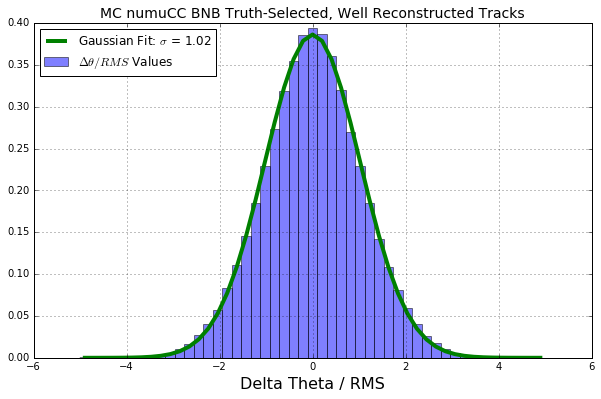

In [118]:
dummy = deflection_plot(-5,5,50,extraquery=None)
if anatype == 'singletrack_data':
    dummy = deflection_plot(-5,5,50,extraquery='not maybe_bad')
if anatype == 'singletrack_MC':
    dummy = deflection_plot(-5,5,50,extraquery='MCT_PDG == 13 or MCT_PDG == -13')

In [119]:
#reco-true/true
def fractional_bias_plot(xvar = 'full_range_energy', xbins = np.linspace(0.35,1,10),
                   yvar = 'full_MCS_energy', plot_bin_distributions = False, extraquery = None):

    binning = xbins
    binwidth = float(binning[1]-binning[0])
    bincenters = binning + (binwidth/2)
    myreses, mystds, myerrs = [], [], []

    for x in xrange(len(binning)-1):
        
        binmin = binning[x]
        binmax = binning[x+1]
        #print "binmin = %0.2f, binmax = %0.2f"% ( binmin, binmax )
        myquery = '%s > %f and %s < %f'%(xvar,binmin,xvar,binmax)
        if anatype == 'singletrack_data': 
            myquery += ' and not maybe_bad'
        if extraquery is not None:
            myquery += ' and %s' % extraquery
            
        mydf = df.query(myquery)
        true = mydf[xvar].values
        reco = mydf[yvar].values
        mymean = ((reco-true)/true).mean()
        mystd = ((reco-true)/true).std()
        myerr = mystd / np.sqrt( float(len(true)) )
        myreses.append( mymean )
        mystds.append( mystd )
        myerrs.append( myerr )
        
        if plot_bin_distributions:
            plt.figure(figsize=(5,3))
            mybins = np.linspace(-.8,.8,20)
            plt.hist((reco-true)/true,color='r',alpha=0.5,label='%d Entries'%len((reco-true)/true),\
                     bins=mybins)
            titlestring = '$\\frac{%s - %s}{%s}$ for $%s$ in %0.2f $\\rightarrow$ %0.2f GeV'% \
            (latextitles[yvar],latextitles[xvar],latextitles[xvar],latextitles[xvar],binmin,binmax)
            t =plt.title(titlestring,fontsize=16)
            #move the title up a bit
            t.set_y(1.04) 
            plt.grid(True)
            
            plt.xlabel('$\\frac{%s - %s}{%s}$'%(latextitles[yvar],latextitles[xvar],latextitles[xvar]),fontsize=16)
            plt.ylabel('Counts',fontsize=16)
            plt.xlim((-0.8,0.8))
            plt.legend(loc=1)
            
    plt.figure(figsize=(10,6))
    plt.errorbar(bincenters[:-1],myreses,yerr=myerrs,fmt='ro--',label='Mean of Distribution, Errors = std/sqrt(N)')
    plt.ylabel('mean($\\frac{%s - %s}{%s}$)'%(latextitles[yvar],latextitles[xvar],latextitles[xvar]),fontsize=25)
    plt.xlabel('%s'%titles[xvar],fontsize=15)
    plt.grid(True)
    plt.legend(loc='best')
    t = plt.title('Fractional Bias: %s'%titles[anatype],fontsize=16)
    t.set_y(1.04) 

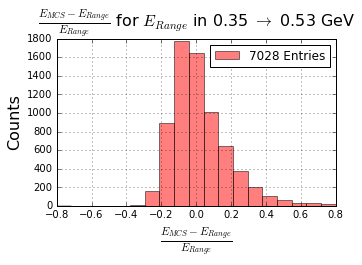

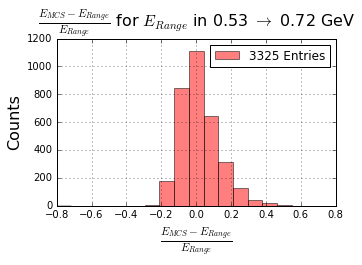

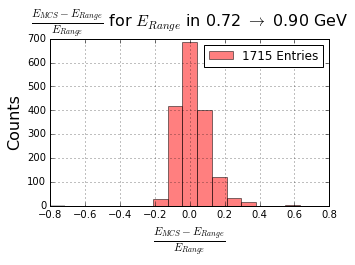

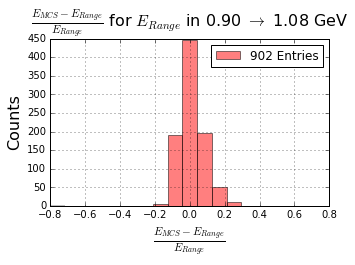

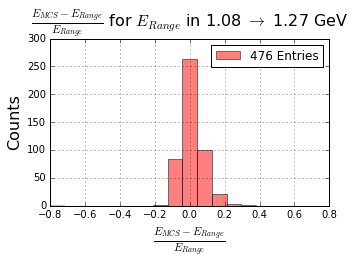

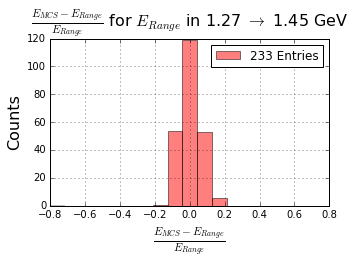

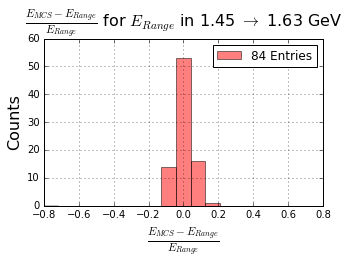

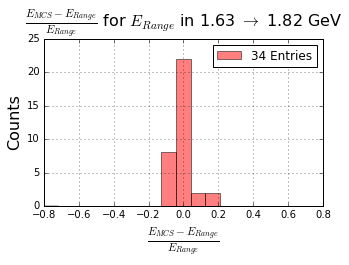

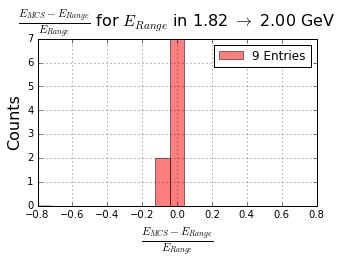

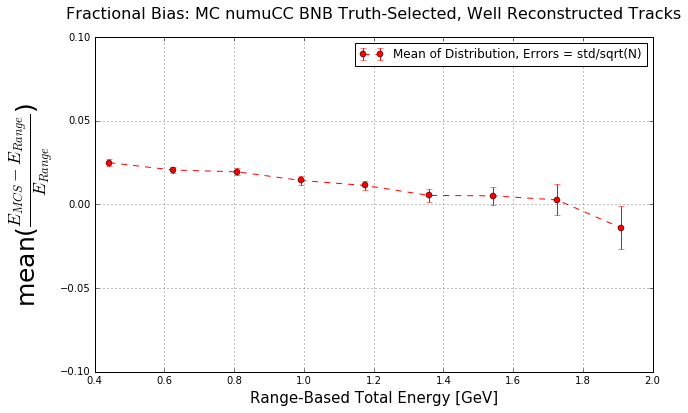

In [120]:
#fractional_bias_plot()
#blah = plt.ylim((-.2,.2))
#fractional_bias_plot(xvar='true_E',yvar='full_range_energy',xbins=np.linspace(0.35,2,10),
#                    plot_bin_distributions = True)
#blah = plt.ylim((-.05,.05))

#fractional_bias_plot(xvar='full_range_energy',xbins=np.linspace(0.35,2,10),
#                    plot_bin_distributions = True)
#blah = plt.ylim((-.1,.1))

fractional_bias_plot(xvar='full_range_energy',xbins=np.linspace(0.35,2,10),
                    plot_bin_distributions = True)#, extraquery = 'MCT_PDG == 13 or MCT_PDG == -13')
blah = plt.ylim((-.1,.1))


In [127]:

#Here I fit the resolution to a realistic resolution equation
def res_eqtn(E,a,b,c):
    return np.sqrt(np.square(a/np.sqrt(E)) + np.square(b/E) + np.square(c))

#def res_eqtn(x,a):
#    return a/np.sqrt(x)

#def res_eqtn(E,a,b,c):
#    return np.sqrt(np.square(a/np.sqrt(1./E)) + np.square(b/(1./E)) + np.square(c))


#reco-true/true
def resolution_plot(xvar = 'full_range_energy', xbins = np.linspace(0.35,1,10), draw_fit = True,
                   yvar = 'full_MCS_energy', extraquery = None):
    
    #This includes a fit to a realistic resolution equation
    
    binning = xbins
    binwidth = float(binning[1]-binning[0])
    bincenters = binning + (binwidth/2)
    myreses, mystds, myerrs = [], [], []
    myN = []
    for x in xrange(len(binning)-1):
        
        binmin = binning[x]
        binmax = binning[x+1]
        #print "binmin = %0.2f, binmax = %0.2f"% ( binmin, binmax )
        myquery = '%s > %f and %s < %f'%(xvar,binmin,xvar,binmax)
        if anatype == 'singletrack_data':
            myquery += ' and not maybe_bad'
        if extraquery is not None:
            myquery += ' and %s' % extraquery
            
        mydf = df.query(myquery)
        true = mydf[xvar].values
        reco = mydf[yvar].values
        mymean = ((reco-true)/true).mean()
        mystd = ((reco-true)/true).std()
        #Error of standard deviation is sigma/sqrt(2N)
        myerr = mystd / np.sqrt( 2 * float(len(true)) )
        myN.append(len(true))
        myreses.append( mymean )
        mystds.append( mystd )
        myerrs.append( myerr )
            
    plt.figure(figsize=(10,6))
    plt.errorbar(bincenters[:-1],mystds,yerr=myerrs,fmt='o--',label='Std of Distribution, Errors = std/sqrt(2N)')
    plt.ylabel('std($\\frac{%s - %s}{%s}$)'%(latextitles[yvar],latextitles[xvar],latextitles[xvar]),fontsize=25)
    plt.xlabel('%s'%titles[xvar],fontsize=15)
    plt.grid(True)
    t = plt.title('Energy Resolution: %s' % titles[anatype],fontsize=16)
    #move the title up a bit
    t.set_y(1.04) 
    
    #print 'E values:'
    #print bincenters[:-1]
    #print 'MEANS:'
    #print myreses
    #print 'STDs:'
    #print mystds
    #print 'N entries in each distribution:'
    #print myN
    #Fit to custom resolution function and return results
    
    if draw_fit:
        popt, pcov = curve_fit(res_eqtn, bincenters[:-1], mystds, sigma=myerrs)
        
        fitx = np.linspace(0.35,1,100)
        fity = res_eqtn(fitx,popt[0],popt[1],popt[2])
        labelstring = 'Resolution Fit: '
        labelstring += '$[\\frac{a}{\sqrt{E}} \circ \\frac{b}{E} \circ c]$'
        plt.plot(fitx,fity,'r-',label=labelstring)
   
        plt.legend(loc='best')
    
        return popt, pcov
    else:
        plt.legend(loc='best')
        return (-1, -1)

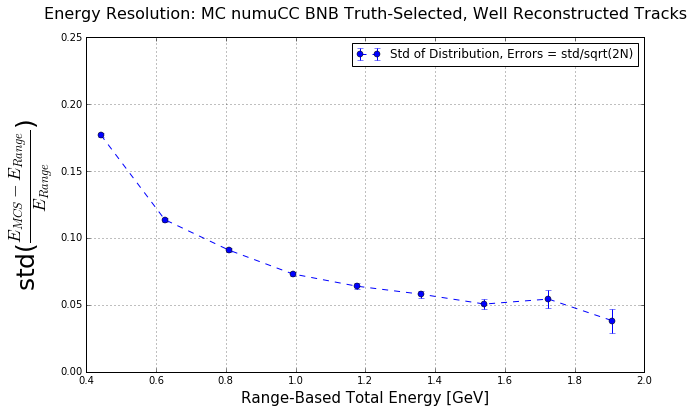

In [128]:
#first, second = resolution_plot(xvar='true_E',draw_fit=False,yvar='full_range_energy',
#                                xbins=np.linspace(0.35,2,10))
#blah = plt.ylim((0,0.05))
#first, second = resolution_plot(xvar='true_E',draw_fit=False)
#blah = plt.ylim((0,0.4))
#first, second = resolution_plot(xvar='full_range_energy',draw_fit=False,xbins=np.linspace(0.35,2,10))
#blah = plt.ylim((0,0.25))

first, second = resolution_plot(xvar='full_range_energy',draw_fit=False,xbins=np.linspace(0.35,2,10),\
                               extraquery = 'MCT_PDG == 13 or MCT_PDG == -13')
blah = plt.ylim((0,0.25))